## Description

### Problem

#### Objective:
Energy savings is one of the important area of focus our current world. Energy savings has two key elements:

* Forecasting future energy usage without improvements
* Forecasting energy use after a specific set of improvements have been implemented

Once we have implemented a set of improvements, the value of energy efficiency improvements can be challenging as there's no way to truly know **how much energy a building would have used without the improvements**. The best we can do is to build counterfactual models. 

We build these counterfactual models across four energy types:
* **chilled water**
* **electricity**
* **hot water**
* **steam**

based on historic usage rates and observed weather.

### Data

#### Dataset:
The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

##### train.csv

* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* `timestamp` - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

##### building_meta.csv

* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

##### weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##### test.csv

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

## Loading Data

#### TO DO:

* load data tables


* join train and metadata tables
* join train and weather tables

In [1]:
import pandas as pd
import os

In [2]:
%%time
building_metadata = pd.read_csv('data' + os.sep + 'building_metadata.csv')

Wall time: 98.4 ms


In [3]:
%%time
train = pd.read_csv('data' + os.sep + 'train.csv')

Wall time: 16.3 s


In [ ]:
# %%time
# test = pd.read_csv('data' + os.sep + 'test.csv')

In [ ]:
# weather_train = pd.read_csv('data' + os.sep + 'weather_train.csv')

In [ ]:
# weather_test = pd.read_csv('data' + os.sep + 'weather_test.csv')

In [ ]:
# rename timestamps columns
# train.columns = ['building_id', 'meter', 'ti   mestamp_meter', 'meter_reading']
# test.columns = ['row_id', 'building_id', 'meter', 'timestamp_meter']

# weather_train.columns = ['site_id', 'timestamp_weather', 'air_temperature', 'cloud_coverage', 'dew_temperature', \
#                         'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
# weather_test.columns = ['site_id', 'timestamp_weather', 'air_temperature', 'cloud_coverage', 'dew_temperature', \
#                         'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

In [ ]:
# test_data = building_metadata.copy()
# test_data = test_data.join(test.set_index('building_id'), on='building_id', how='inner')
# test_data.head()

In [ ]:
# test_data.shape

In [4]:
train_data = building_metadata.copy()
train_data = train_data.join(train.set_index('building_id'), on='building_id', how='inner')
train_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0


In [5]:
train_data.shape

(20216100, 9)

In [ ]:
# test_data = test_data.join(weather_test.set_index('site_id'), on='site_id', how='inner')

In [ ]:
# train_data = train_data.join(weather_train.set_index('site_id'), on='site_id', how='inner')

## Preprocessing

### Data Cleaning

In [172]:
import numpy as np

#### TO DO:

* NaNs counting
* How to fill the blanks?


* Some columns processing (LabelEncoder/...)
* Preprocessing for each building
* Split table into features and targets

In [26]:
# Convert date to datetime format
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

# Extract and store year, month, day, hour
train_data['year'] = train_data['timestamp'].dt.year
train_data['month'] = train_data['timestamp'].dt.month
train_data['day'] = train_data['timestamp'].dt.day
train_data['hour'] = train_data['timestamp'].dt.hour

train_data = train_data.drop(['timestamp'], axis=1)

In [42]:
train_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,meter_reading,year,month,day,hour
0,0,0,Education,7432,2008.0,NaN,0,0.0,2016,1,1,0
0,0,0,Education,7432,2008.0,NaN,0,0.0,2016,1,1,1
0,0,0,Education,7432,2008.0,NaN,0,0.0,2016,1,1,2
0,0,0,Education,7432,2008.0,NaN,0,0.0,2016,1,1,3
0,0,0,Education,7432,2008.0,NaN,0,0.0,2016,1,1,4


In [179]:
new_columns = list(train_data.columns)
new_columns.append('meter_reading_mean')

train = pd.DataFrame(columns=new_columns)

building_ids = train_data['building_id'].unique()[1:100]
train_d = train_data[train_data['building_id'] == 0]
for building_id in building_ids:
    train_d = train_d.append(train_data[train_data['building_id'] == building_id], ignore_index=True)
train_d

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,meter_reading,year,month,day,hour
0,0,0,Education,7432,2008.0,NaN,0,0.0000,2016,1,1,0
1,0,0,Education,7432,2008.0,NaN,0,0.0000,2016,1,1,1
2,0,0,Education,7432,2008.0,NaN,0,0.0000,2016,1,1,2
3,0,0,Education,7432,2008.0,NaN,0,0.0000,2016,1,1,3
4,0,0,Education,7432,2008.0,NaN,0,0.0000,2016,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1025539,0,99,Office,2260,2016.0,NaN,0,10.6923,2016,12,31,19
1025540,0,99,Office,2260,2016.0,NaN,0,9.9517,2016,12,31,20
1025541,0,99,Office,2260,2016.0,NaN,0,9.0610,2016,12,31,21
1025542,0,99,Office,2260,2016.0,NaN,0,8.5218,2016,12,31,22


In [180]:
%%time
# from tqdm import tqdm
for building_id in train_d['building_id'].unique():
    buildingID = train_d[train_d['building_id'] == building_id]
    for month_id in buildingID['month'].unique():
        buildingIDmonthID = buildingID[buildingID['month'] == month_id]
        for day_id in buildingIDmonthID['day'].unique():
            buildingIDmonthIDdayID = buildingIDmonthID[buildingIDmonthID['day'] == day_id]
            train = train.append(buildingIDmonthIDdayID[0:1], ignore_index=True)
            train.set_value(train.shape[0]-1, 'meter_reading_mean', buildingIDmonthIDdayID['meter_reading'].mean())

D:\Anaconda\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


Wall time: 14min 33s


In [182]:
train[['primary_use', 'floor_count']].groupby(['primary_use']).mean()

,floor_count
primary_use,
Education,NaN
Entertainment/public assembly,NaN
Lodging/residential,NaN
Office,NaN
Other,NaN
Parking,NaN
Retail,NaN


In [276]:
TR = train.drop(['hour', 'year', 'building_id', 'floor_count', 'meter_reading'], axis=1)

### TO DO
meter == 0

In [277]:
TR = TR[TR['meter'] == 0]

In [278]:
from sklearn.preprocessing import LabelEncoder
TR['primary_use'] = LabelEncoder().fit_transform(TR['primary_use'])
TR

,day,meter,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,0,0,1,0,0,7432,2008.0
1,2,0,0,1,0,0,7432,2008.0
2,3,0,0,1,0,0,7432,2008.0
3,4,0,0,1,0,0,7432,2008.0
4,5,0,0,1,0,0,7432,2008.0
...,...,...,...,...,...,...,...,...
36204,27,0,10.3935,12,3,0,2260,2016.0
36205,28,0,10.3941,12,3,0,2260,2016.0
36206,29,0,9.98927,12,3,0,2260,2016.0
36207,30,0,7.15778,12,3,0,2260,2016.0


In [279]:
TR.index = range(TR.shape[0])
TR

,day,meter,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,0,0,1,0,0,7432,2008.0
1,2,0,0,1,0,0,7432,2008.0
2,3,0,0,1,0,0,7432,2008.0
3,4,0,0,1,0,0,7432,2008.0
4,5,0,0,1,0,0,7432,2008.0
...,...,...,...,...,...,...,...,...
36058,27,0,10.3935,12,3,0,2260,2016.0
36059,28,0,10.3941,12,3,0,2260,2016.0
36060,29,0,9.98927,12,3,0,2260,2016.0
36061,30,0,7.15778,12,3,0,2260,2016.0


In [280]:
TR = TR.apply(pd.to_numeric)
TR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36063 entries, 0 to 36062
Data columns (total 8 columns):
day                   36063 non-null int64
meter                 36063 non-null int64
meter_reading_mean    36063 non-null float64
month                 36063 non-null int64
primary_use           36063 non-null int32
site_id               36063 non-null int64
square_feet           36063 non-null int64
year_built            36063 non-null float64
dtypes: float64(2), int32(1), int64(5)
memory usage: 2.1 MB


In [281]:
TR = TR.drop(['meter'], axis=1)
TR

,day,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,0.000000,1,0,0,7432,2008.0
1,2,0.000000,1,0,0,7432,2008.0
2,3,0.000000,1,0,0,7432,2008.0
3,4,0.000000,1,0,0,7432,2008.0
4,5,0.000000,1,0,0,7432,2008.0
...,...,...,...,...,...,...,...
36058,27,10.393546,12,3,0,2260,2016.0
36059,28,10.394108,12,3,0,2260,2016.0
36060,29,9.989267,12,3,0,2260,2016.0
36061,30,7.157779,12,3,0,2260,2016.0


### Statistics

#### TO DO:

* correlation of features between themselves
* correlation of features with target values
* draw histograms, barcharts, ...


* drop unnecessary columns or join some features
* drop data outliers (data.column.quantile)

Create powers of features

In [282]:
target = TR['meter_reading_mean']
features = TR.drop(['meter_reading_mean'], axis=1)

In [283]:
features.head()

,day,month,primary_use,site_id,square_feet,year_built
0,1,1,0,0,7432,2008.0
1,2,1,0,0,7432,2008.0
2,3,1,0,0,7432,2008.0
3,4,1,0,0,7432,2008.0
4,5,1,0,0,7432,2008.0


In [284]:
target.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: meter_reading_mean, dtype: float64

In [285]:
dict = {}

features_powered = features ** 2

# give columns appropriate names
data_2power = features_powered
data_2power['meter_reading_mean'] = target
correlation = data_2power.corr()
target_column = correlation['meter_reading_mean']
for i in range(target_column.shape[0]):
    key = target_column.index.values[i]
    value = target_column.iloc[i]
    dict[key] = value
correlation['meter_reading_mean'].head()
print(dict)

target_column.head()

{'day': 0.02487662807065501, 'month': 0.21350062927165958, 'primary_use': -0.20798418851417824, 'site_id': nan, 'square_feet': -0.016501455902678683, 'year_built': 0.11293623488621295, 'meter_reading_mean': 1.0}


day            0.024877
month          0.213501
primary_use   -0.207984
site_id             NaN
square_feet   -0.016501
Name: meter_reading_mean, dtype: float64

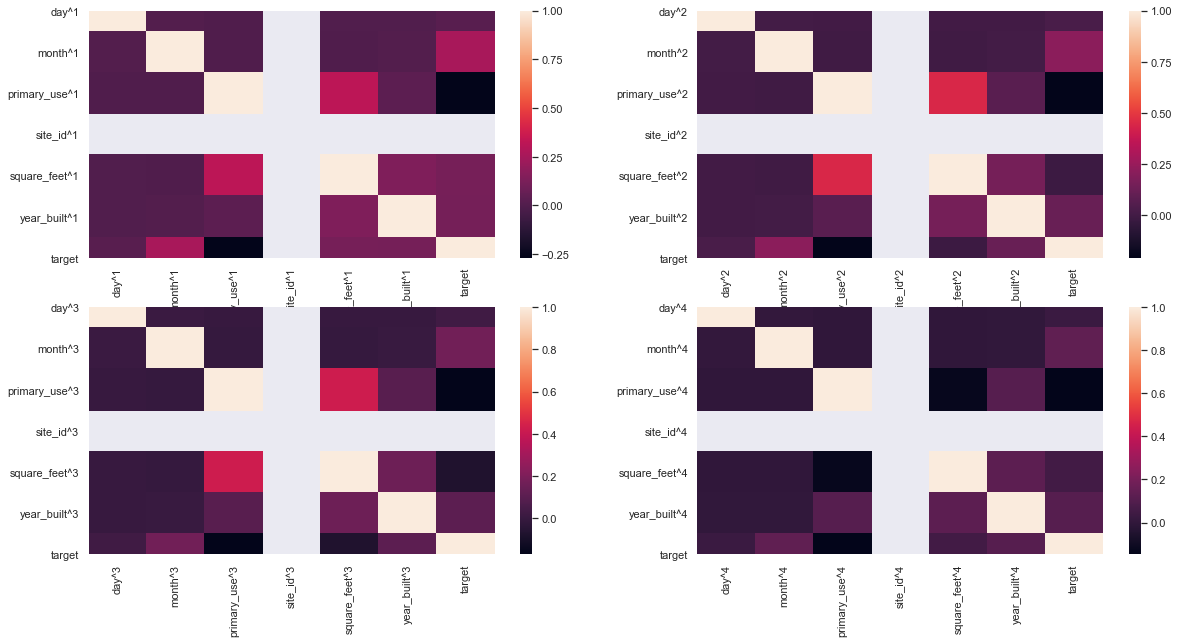

In [337]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
 
plt.figure(figsize=(20,10))
 
list_of_powered_features = []
features_corr_dict = {}
 
for i in range(1,5):
    new_columns = []
    features_powered = features ** i
    # give columns appropriate names
    for column in features_powered.columns:
        new_columns.append(column + '^{0}'.format(i))
    features_powered.columns = new_columns
 
    list_of_powered_features.append(features_powered)
    data_2power = features_powered
    data_2power['target'] = target
    correlation = data_2power.corr()
    # add values to the dictionary of feature correlation
    target_column = correlation['target']
    for j in range(target_column.shape[0]):
        key = target_column.index.values[j]
        if key != 'target':
            value = target_column.iloc[j]
            features_corr_dict[key] = value
 
    plt.subplot(2,2,i)
    ax = sns.heatmap(correlation)

In [338]:
sorted_features_corr_dict = sorted(features_corr_dict.items(), key=lambda kv: kv[1])

In [339]:
sorted_features_corr_dict.reverse()

#### Top 5 of correlating features

In [340]:
top5 = []

for i in range(1,6):
    feature_name = sorted_features_corr_dict[i][0]
    top5.append(feature_name)
    
print(top5)

['site_id^3', 'site_id^2', 'site_id^1', 'month^1', 'month^2']


In [341]:
top_corr_features = pd.DataFrame()
for feature in top5:
    index = int(feature[-1]) - 1
    feature_powered = list_of_powered_features[index]
    top_corr_features[feature] = feature_powered[feature]

In [342]:
top_corr_features

,site_id^3,site_id^2,site_id^1,month^1,month^2
0,0,0,0,1,1
1,0,0,0,1,1
2,0,0,0,1,1
3,0,0,0,1,1
4,0,0,0,1,1
...,...,...,...,...,...
36058,0,0,0,12,144
36059,0,0,0,12,144
36060,0,0,0,12,144
36061,0,0,0,12,144


## Metrics

#### TO DO:

* check unbalancing!
* What metrics will we use and why?

Evaluation Metric
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$

We have chosen RMSLE not to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers (in this dataset they might go up to around 7 thousand kw/h). What is more, for this paticular problem overestimating meter readings is better than underestimating them since the goal is to find how much imporovements of buildings helped reduce their energy consumption. In this case again RMSLE is more appropriate than MSE.

In [291]:
# from sklearn.metrics import ...

## ML models

### Preprocessing

#### TO DO:

* split into train (80%) and test (val) (20%)
* OneHotEncoding for categorial features
* normalize (standardize) data

In [292]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error


random_state = 1

In [301]:
categorical_data_indices = [2, 3]
numerical_data_indices = [0, 1, 4, 5]

In [302]:
pipe_ridge = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('encoding', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, categorical_data_indices])),
                                      ('encoding', OneHotEncoder())
                                      ])),
        ('scaling', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, numerical_data_indices])),
                                     ('scaling', StandardScaler())
                                     ]))
    ])),
    ('model', Ridge(random_state=random_state))
])

In [320]:
pipe_lasso = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('encoding', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, categorical_data_indices])),
                                      ('encoding', OneHotEncoder())
                                      ])),
        ('scaling', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, numerical_data_indices])),
                                     ('scaling', StandardScaler())
                                     ]))
    ])),
    ('model', Lasso(random_state=random_state))
])

In [303]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=random_state)

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler

### Linear model

#### TO DO:

* Choose some linear models
* Find a good combination of hyperparameters via cross-validation
* plot dependency between score and some hyperparameter

In [307]:
param_grid = {'model__alpha': np.logspace(-20, 20, 41, base=2)}
grid_search_ridge = GridSearchCV(pipe_ridge, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_search_ridge.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % -grid_search_ridge.best_score_)
print(grid_search_ridge.best_params_)

Best parameter (CV score=363943.521):
{'model__alpha': 0.03125}


D:\Anaconda\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
D:\Anacon

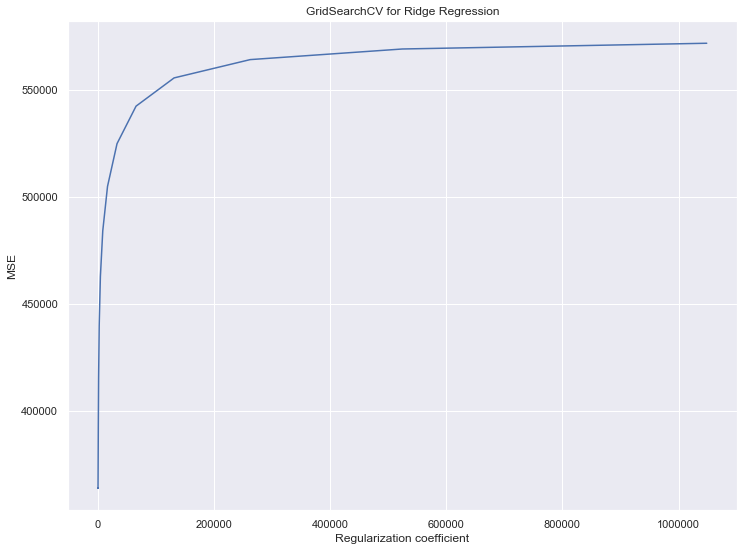

In [315]:
results_ridge = grid_search_ridge.cv_results_
plt.figure(figsize=[12., 9.])
plt.title("GridSearchCV for Ridge Regression")
plt.xlabel("Regularization coefficient")
plt.ylabel("MSE")

x_axis = np.array(param_grid['model__alpha'], dtype=float)
y_axis = -results_ridge['mean_test_score']
plt.plot(x_axis, y_axis)

In [321]:
grid_search_lasso = GridSearchCV(pipe_lasso, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_search_lasso.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % -grid_search_lasso.best_score_)
print(grid_search_lasso.best_params_)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
D:\Anacon

Best parameter (CV score=363946.528):
{'model__alpha': 0.00390625}


D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 720752237.152977, tolerance: 1657258.4795272048
  max_iter, tol, rng, random, positive)


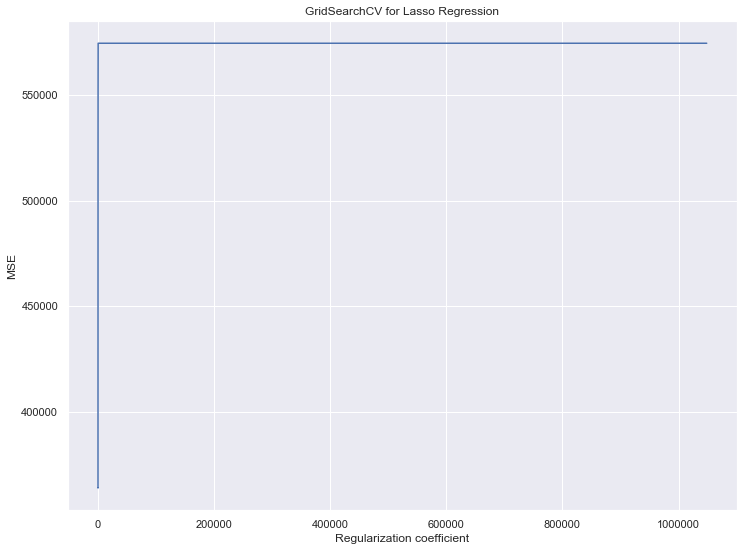

In [324]:
results_lasso = grid_search_lasso.cv_results_
plt.figure(figsize=[12., 9.])
plt.title("GridSearchCV for Lasso Regression")
plt.xlabel("Regularization coefficient")
plt.ylabel("MSE")

x_axis = np.array(param_grid['model__alpha'], dtype=float)
y_axis = -results_lasso['mean_test_score']
plt.plot(x_axis, y_axis)

In [336]:
from sklearn.metrics import mean_squared_error

if grid_search_lasso.best_score_ < grid_search_ridge.best_score_:
    fin_model = Lasso(alpha=grid_search_lasso.best_params_['model__alpha'], random_state=random_state)
else: 
    fin_model = Ridge(alpha = grid_search_ridge.best_params_['model__alpha'], random_state=random_state)

fin_model.fit(X_train, y_train)
y_pred = fin_model.predict(X_val)
mean_squared_error(y_pred, y_val)

441924.18354106374

In [ ]:
# from sklearn.linear_model import ???LogisticRegression
#???? from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GridSearchCV

## Analyzing of results

#### TO DO:

* Make `test.csv` files with our results
* send them into Kaggle in turn

### Comparison of models

#### TO DO:

* Compare results of Linear and Classifier models (take test scores from kaggle)
* Write conclusion